In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.optimize as so
import itertools as it

In [2]:
def background_subtract(h, m, hsat=1000, value=None):
    if value is None:
        
        _h_upper = h[h>hsat]
        _m_upper = m[h>hsat]
        
        _h_lower = h[h<-hsat]
        _m_lower = m[h<-hsat]
            
        line = lambda x, a, b: a*x + b
        popt_upper, _ = so.curve_fit(line, _h_upper, _m_upper)
        popt_lower, _ = so.curve_fit(line, _h_lower, _m_lower)
        
        value = 0.5*(popt_upper[0]+popt_lower[0])
        
    return m - value*h

In [18]:
colors = {'AG': 'r',
          'FC': 'k',
          'FC+VC': 'b',
          'FC-VC': 'g',
          'FCVC': 'b',
          'FCVCFC': 'g'}

In [4]:
data_20180407_folder = 'C:/Users/pdmurray/Desktop/peyton/Projects/NiCoO_ElectricalEB/Data/2018-04-07_1 NiCoO_Gd_Pt/Piece 6/'
data_20180407_files = {'AG': 'IP ML RT As Grown 2 kOe Slow +5 V',
                       'FC': 'IP ML RT +5-5 V then FC 120 C 10 kOe 5 min 2 kOe Slow',
                       'FC+VC': 'IP ML RT +5-5 V then FC 120 C 10 kOe 5 min 2 kOe Slow +5-10 V, +10 V 14_20',
                       'FC-VC': 'IP ML RT +5-5 V then FC 120 C 10 kOe 5 min 2 kOe Slow +5-10 V, +10 V 14_20,  -10 V 22_40'}

data_20180407 = {key: pd.read_csv(data_20180407_folder+value, 
                                  sep=',', 
                                  names=['Raw Field', 'Raw Moment', 'Temperature', 'Field', 'Moment'],
                                  skiprows=86) for key, value in data_20180407_files.items()}

for key, value in data_20180407.items():
    data_20180407[key] = value[:-1]

In [5]:
data_20180430_folder = 'C:/Users/pdmurray/Desktop/peyton/Projects/NiCoO_ElectricalEB/Data/2018-04-30_1 NiCoO_2_5mTorr/Piece 4 (The one from the boot)/'
data_20180430_files = {'AG': 'IP ML RT As Grown 2 kOe',
                       'FC': 'IP ML RT FC 120 C 10 kOe 5 min 2 kOe',
                       'FCVC': 'IP ML RT FC 120 C 10 kOe 5 min 2 kOe +10 V 4h',
                       'FCVCFC': 'IP ML RT FC 120 C 10 kOe 5 min 2 kOe +10 V 4h FC'}

data_20180430 = {key: pd.read_csv(data_20180430_folder+value, 
                                  sep=',', 
                                  names=['Raw Field', 'Raw Moment', 'Temperature', 'Field', 'Moment'],
                                  skiprows=86) for key, value in data_20180430_files.items()}

for key, value in data_20180430.items():
    data_20180430[key] = value[:-1]

In [6]:
data_20180430['FCVCFC'].tail()

,Raw Field,Raw Moment,Temperature,Field,Moment
397,+1.920886E+03,0.000018,20.57433,1920.886,0.000007
398,+1.941381E+03,0.000018,20.57433,1941.381,0.000007
399,+1.960872E+03,0.000017,20.57433,1960.872,0.000006
400,+1.981456E+03,0.000018,20.57433,1981.456,0.000006
401,+2.000926E+03,0.000017,20.57445,2000.926,0.000006


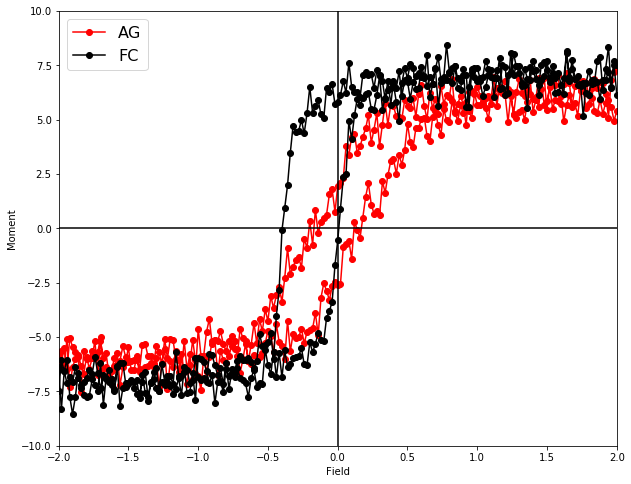

In [29]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
for key, value in data_20180407.items():
    if key in ['AG', 'FC']:
        m_corrected = background_subtract(value['Field'], value['Moment'], hsat=1000)
        ax.plot(1e-3*value['Field'], 1e6*m_corrected, linestyle='-', marker='o', color=colors[key], label=key)
ax.set_xlim(-2, 2)
ax.set_ylim(-10, 10)
ax.axhline(color='k')
ax.axvline(color='k')
ax.legend(prop={'size': 16})
ax.set_xlabel('Field')
ax.set_ylabel('Moment')
fig.savefig(fname='2018-04-07_AG.svg')

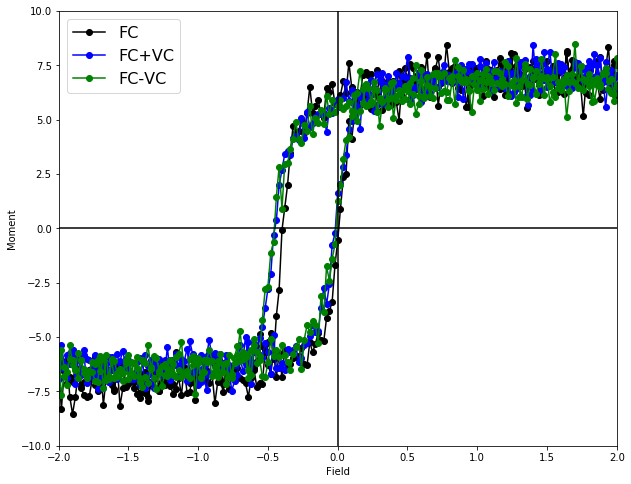

In [28]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
for key, value in data_20180407.items():
    if key in ['FC', 'FC+VC', 'FC-VC']:
        m_corrected = background_subtract(value['Field'], value['Moment'], hsat=1000)
        ax.plot(1e-3*value['Field'], 1e6*m_corrected, linestyle='-', marker='o', color=colors[key], label=key)
ax.set_xlim(-2, 2)
ax.set_ylim(-10, 10)
ax.axhline(color='k')
ax.axvline(color='k')
ax.legend(prop={'size': 16})
ax.set_xlabel('Field')
ax.set_ylabel('Moment')
fig.savefig(fname='2018-04-07_FC-VC.svg')

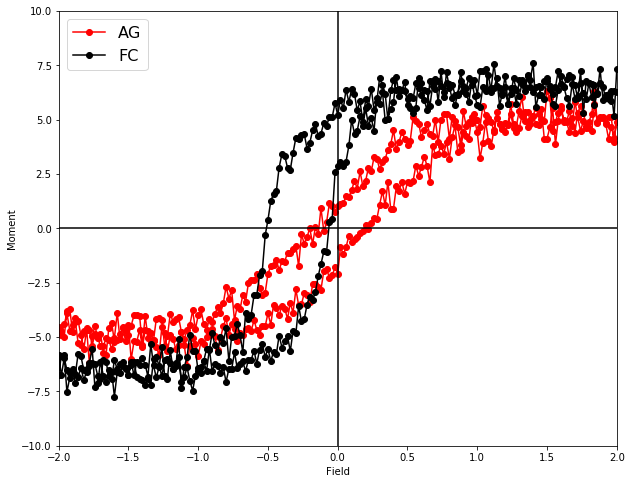

In [30]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
for key, value in data_20180430.items():
    if key in ['AG', 'FC']:
        m_corrected = background_subtract(value['Field'], value['Moment'], hsat=1000)
        ax.plot(1e-3*value['Field'], 1e6*m_corrected, linestyle='-', marker='o', color=colors[key], label=key)
ax.set_xlim(-2, 2)
ax.set_ylim(-10, 10)
ax.axhline(color='k')
ax.axvline(color='k')
ax.legend(prop={'size': 16})
ax.set_xlabel('Field')
ax.set_ylabel('Moment')
fig.savefig(fname='2018-04-30_AG.svg')

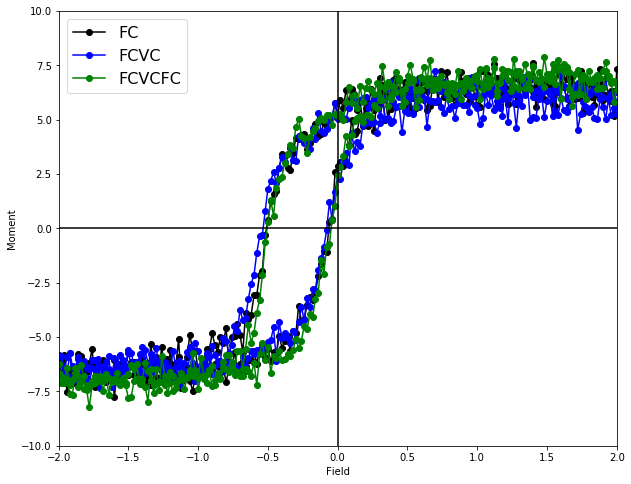

In [26]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
for key, value in data_20180430.items():
    if key in ['FC', 'FCVC', 'FCVCFC']:
        m_corrected = background_subtract(value['Field'], value['Moment'], hsat=1000)
        ax.plot(1e-3*value['Field'], 1e6*m_corrected, linestyle='-', marker='o', color=colors[key], label=key)
ax.set_xlim(-2, 2)
ax.set_ylim(-10, 10)
ax.axhline(color='k')
ax.axvline(color='k')
ax.legend(prop={'size': 16})
ax.set_xlabel('Field')
ax.set_ylabel('Moment')
fig.savefig(fname='2018-04-30_FCVCFC.svg')